    Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов
Эксперимент проходил с 2022-09-03 по 2022-09-09 включительно. 

    Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве
контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
Ваша задача — проанализировать данные АB-теста. 

#### Задачи:
1.	Выбрать метод анализа и сравнить CTR в двух группах 
2.	Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как
     сработали? 
3.	Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4.	Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.


#### Подключимся к Базе данных и выведем нужные данные 

In [14]:
import pandas as pd
import pandahouse as ph
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

sns.set(rc={'figure.figsize':(15,8)})

In [30]:
connection = {
'host': 'https://clickhouse.lab.karpov.courses',
'password': 'dpo_python_2020',
'user': 'student',
'database': 'simulator_20220820'}

q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
and exp_group in (2,1)
GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(q, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,17070,17070,17070,17070
2,16869,16869,16869,16869


у нас есть датафрейм с количеством пользователей, событий и метрикой CTR

    - контрольная группа из 17070 пользователей
    - тестовая группа из 16869 пользователей 

### Посмтотрим на распределение обоих CTR на гарфике  

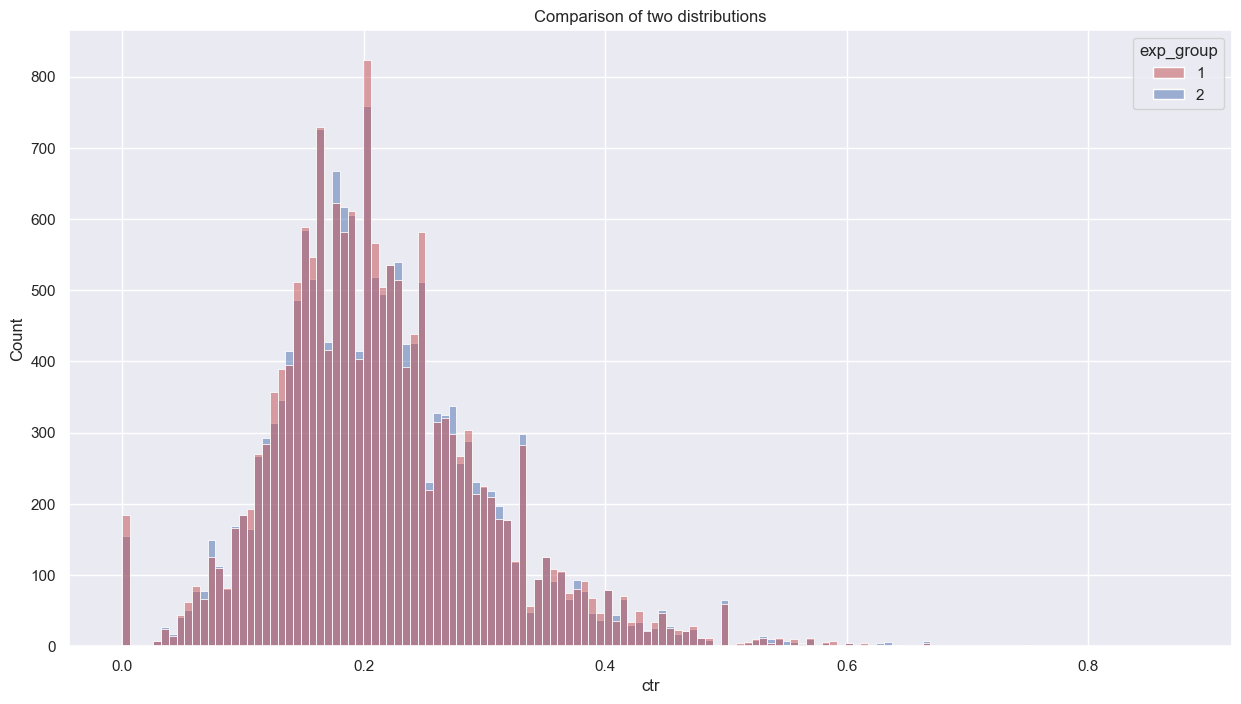

In [31]:
sns.histplot(data = df, x = 'ctr', hue = 'exp_group',
            palette = ['r', 'b'], alpha = 0.5, kde = False)

plt.title('Comparison of two distributions')

sns.set()

визуально распределения не имеют больших различий, по форме они ассиметричны со смещением вправо.

### Выбрать метод анализа и сравнить CTR в двух группах

Буду использовать разные методы сравнения двух групп по очереди, 
для демонстрации методов с которыми познакомилась : 

       - Т-тест без предобработок
       - тест Манна Уитни
       - Сглаживание Лаплассом и т-тест поверх
       - Пауссоновский бутстреп 
       - Бакетное преобразование

#### Сравню 2 группы через т-тест без предобработок
суть теста основана на выявлении равенства средних по Центральной предельной теореме,
возьмем 95% дверительный интервал тогда гипотезы будут:

   **Н0**: M1 = M2  - при уровне альфа больше 0.05
   
   **H1**: M1!= M2  - при уровне альфа меньше 0.05

In [32]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var = False)

Ttest_indResult(statistic=-0.41347637473349386, pvalue=0.6792602410005473)

#### Сравню 2 группы через ранговый тест Манна Уитни
интерпретация результатов через гипотезу доминирования: P(X>Y) = (X<Y)

   **H0**: P(X>Y) = (X<Y) - - при уровне альфа больше 0.05
   
   **H1**: P(X>Y)!= (X<Y) - - при уровне альфа меньше 0.05

In [33]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=143551924.0, pvalue=0.6376814173341009)

По т-тесту средниb двух выборок входят в интервалы доверия,
а по тесту Манна Уитни группы равнодоминантные 

**У обоих тестов p-value около = 0.6 , значит что существенных различий не выявлено**


### использую метод Лаплас  сглаживания и применю т-тест сверху


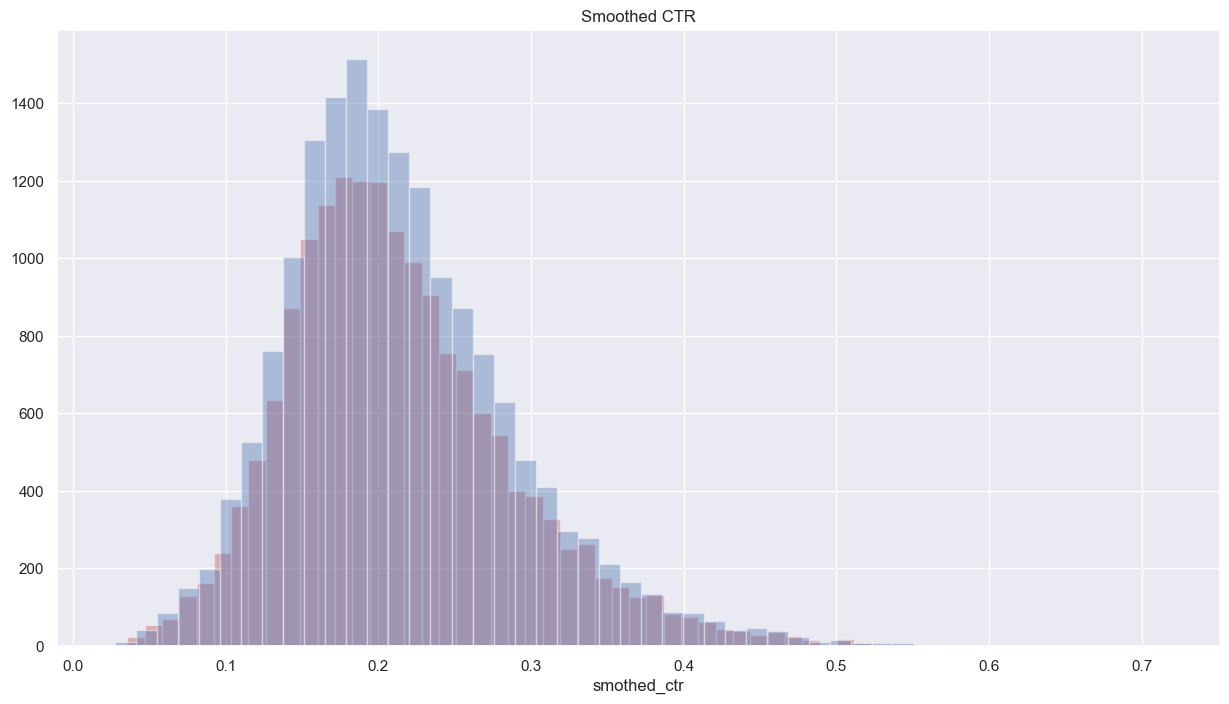

In [35]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1)
group2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis = 1)

sns.distplot(group1.smothed_ctr, kde = False, color = 'r')
sns.distplot(group2.smothed_ctr, kde = False)

plt.title('Smoothed CTR')
sns.set()

In [57]:
stats.ttest_ind(group1[group1.exp_group == 1].smothed_ctr,
                group2[group2.exp_group == 2].smothed_ctr,
                equal_var = False)

Ttest_indResult(statistic=-0.2483388243951237, pvalue=0.8038737648711783)

после Лапласса , визуально распределения стали более гладким, без явных выбросов которые могли помешать т-тесту на прошлом шаге
приминение т-теста поверх сглаживания также не показало значимых различий между ctr распределениями, в этом случае p-value стал выше = 0.8

### Сравню 2 распределения ctr в группах методом Пуассоновского бутстрепа
суть метода : мы найдем вероятность успешного нахождения каждого значения в нашем распределении, получим биномальное распределение которое при больших размерам выборок и уменьшении вероятности сходиться к распределению Пауссана 

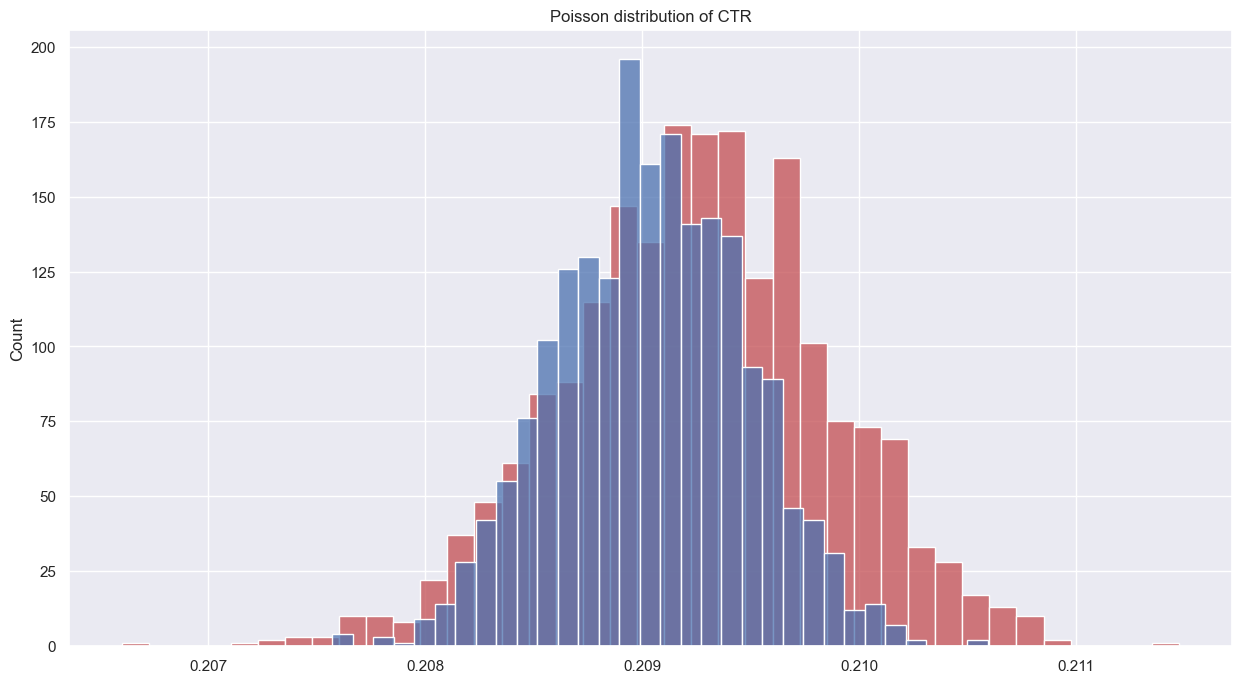

In [21]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap = 2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(2).rvs(
         (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color = 'r')
sns.histplot(ctr2)

plt.title('Poisson distribution of CTR')
sns.set()

на графике видим что распределение тестового CTR левее контрольного ,это говорит о том что результаты стали хуже
и новый алгоритм ухудшил метрику CTR

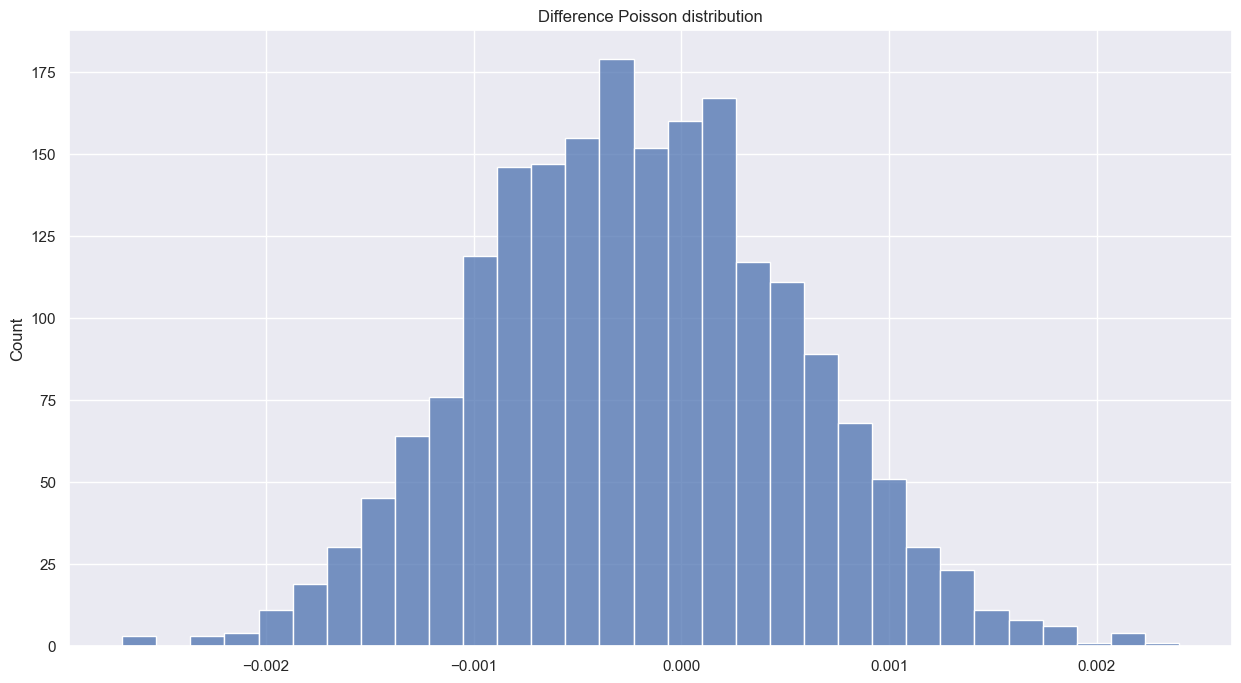

In [25]:
sns.histplot(ctr2-ctr1)

plt.title('Difference Poisson distribution')

sns.set()

на графике выше визуализирована разница 2 пауссоновских распределений,разница находиться в отрицательных значениях слева от нуля
**Вывод**: тестовая группа не показазала значимых результатов на этой выборке

### метод : Бакетное преобразование + т.манна уитни
для начала мы используем хэширование поставив тем самым отдельную метку для каждого наблюдения, чтобы наблюдения распределялись равномерно по бакетам , каждый пользователь ровно в 1 бакет. Затема считается среднее в каждом бакете и сравнивается тестом. Всего возьмем 50 бакетов

**Снова выгрузим данные 2 групп из БД но уже предварительно прохэшируем их**

In [26]:
q2 = """
SELECT exp_group, bucket,
sum(likes)/sum(views) as bucket_ctr,
quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group,
xxHash64(user_id)%50 as bucket,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
and exp_group in (1,2)
GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df = ph.read_clickhouse(q2, connection=connection)

In [27]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                   df[df.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1248.0, pvalue=0.9917494383745994)

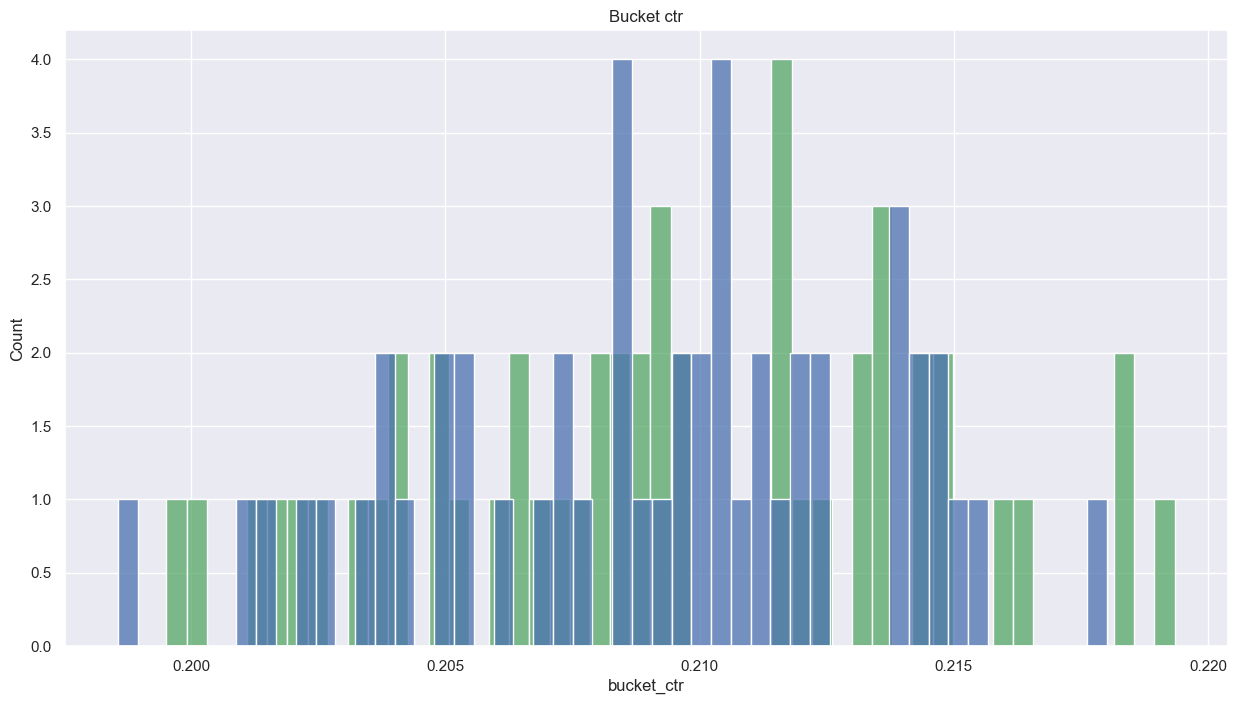

In [28]:
sns.histplot(df[df.exp_group == 1].bucket_ctr, bins = 50, color = 'g')
sns.histplot(df[df.exp_group == 2].bucket_ctr, bins = 50, color = 'b')

plt.title('Bucket ctr')
sns.set()

данные досаточно большие так что можем сравнить не только средние но и квартили

In [ ]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr9,
                   df[df.exp_group == 2].ctr9,
                   alternative = 'two-sided')

анализ распределний бакетного преобразования по средним бакетов и 90квартиля не показали значимых различий

вывод : по данным этого А/Б теста значимых различий между контрольной и тестовой группами не обнаружено,
пауссоновский бутстреп даже показал ухудшение CTR после приминения алгоритма.
Рекомендации: не стоит расскатывать новый алгоритм на всех пользователей 